In [3]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

In [4]:
plt.style.use("cms")
plt.rcParams.update({
    "font.size": 9,
})

In [5]:
#_df_data = pd.read_hdf("fitinputs.h5", "Data")
_df_mc = pd.read_hdf("fitinputs.h5", "MC")
_df_mc_smooth = pd.read_hdf("fitinputs.h5", "MCSmooth")
_df_mc_p4 = pd.read_hdf("fitinputs.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("fitinputs.h5", "MCFlat")

#_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

In [6]:
_df_mc.index.get_level_values("region").unique()


Index(['DoubleElectron', 'DoubleMuon', 'DoubleMuonMu', 'Monojet', 'MonojetQCD',
       'SingleElectron', 'SingleElectronMinus', 'SingleElectronPlus',
       'SingleElectronQCD', 'SingleMuon', 'SingleMuonMinus', 'SingleMuonMu',
       'SingleMuonMuQCD', 'SingleMuonPlus', 'SingleMuonQCD', 'SingleTau'],
      dtype='object', name='region')

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [7]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "MonojetQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleTau": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonMinus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonPlus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [8]:
region_process_variations = {
    ("Monojet", "WJetsToLNu"): [
        "lheScaleWeight",
    ],
    ("Monojet", "ZJetsToNuNu"): [
        "lheScaleWeight",
    ],
    ("SingleMuon", "WJetsToLNu"): [
        "lheScaleWeight",
#        "d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
#        "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
#        "lumi",
    ],
    ("SingleElectron", "WJetsToLNu"): [
        "lheScaleWeight",
#        "d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
#        "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
#        "lumi",
    ],
    ("SingleTau", "WJetsToLNu"): [
        "lheScaleWeight",
#        "d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
#        "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
#        "lumi",
    ],
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc = _df_mc.drop(
                    (region, process, variation+vtype),
                )
            except KeyError:
                pass

/vols/build/cms/sdb15/miniconda2/envs/zinv38/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use gaussian filter smoothing

In [9]:
region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): [],
    ("SingleElectron", "WJetsToLNu"): [],
    ("SingleTau", "WJetsToLNu"): [],
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_smooth.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]


## Use polyfit smoothing

In [11]:
params_major = ["jesTotal", "jerSF", "unclust", "eleIdIsoTight", "tauIdVLoose", "tauIdTight", "pileup", "lhePdfWeight", "prefiring"]
params_minor = ["tauIdVLoose", "tauIdTight", "lhePdfWeight", "prefiring"]

region_process_variations = {
    ("Monojet", "WJetsToLNu"): params_major,
    ("Monojet", "MinorBkgs"): params_minor,
    ("Monojet", "QCD"): params_minor,
    ("Monojet", "ZJetsToNuNu"): params_major,
    ("SingleMuon", "WJetsToLNu"): params_major,
    ("SingleMuon", "MinorBkgs"): params_minor+["muonIdTightStat", "muonIdTightSyst", "muonIsoTightStat", "muonIsoTightSyst"],
    ("SingleMuon", "QCD"): params_minor,
    ("DoubleMuon", "DYJetsToLL"): params_major,
    ("DoubleMuon", "MinorBkgs"): params_minor+["muonIdTightStat", "muonIdTightSyst", "muonIsoTightStat", "muonIsoTightSyst"],
    ("SingleElectron", "WJetsToLNu"): params_major+["eleReco"],
    ("SingleElectron", "MinorBkgs"): params_minor+["eleReco"],
    ("DoubleElectron", "DYJetsToLL"): params_major,
    ("DoubleElectron", "MinorBkgs"): params_minor,
    ("SingleTau", "WJetsToLNu"): params_major,
    ("SingleTau", "MinorBkgs"): params_minor,
    ("SingleTau", "QCD"): params_minor,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [13]:
params_qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco"]
params_minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight"]

process_variations = {
    ("Monojet", "QCD"): params_qcd+["muonIdTightStat", "muonIdTightSyst", "muonIsoTightStat", "muonIsoTightSyst"],
    ("Monojet", "MinorBkgs"): params_minors,
    ("SingleMuon", "MinorBkgs"): params_minors,
    ("SingleMuon", "QCD"): params_qcd,
    ("SingleElectron", "MinorBkgs"): params_minors,
    ("SingleTau", "MinorBkgs"): params_minors,
    ("SingleTau", "QCD"): params_qcd,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_flat.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass

In [15]:
#df_data = _df_data.unstack().unstack().loc[[
#    ("MET", "Monojet"),
#    ("MET", "MonojetQCD"),
#    ("MET", "SingleMuon"),
#    ("MET", "SingleMuonPlus"),
#    ("MET", "SingleMuonMinus"),
#    ("MET", "SingleMuonQCD"),
#    ("MET", "DoubleMuon"),
#    ("MET", "SingleTau"),
#    ("SingleElectron", "SingleElectron"),
#    ("SingleElectron", "SingleElectronPlus"),
#    ("SingleElectron", "SingleElectronMinus"),
#    ("SingleElectron", "SingleElectronQCD"),
#    ("SingleElectron", "DoubleElectron"),
#]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
#df_data.head(5)

In [16]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(5)

sum_w        sum_ww
region     process    variation bin_min bin_max                        
DoubleMuon WJetsToLNu           200.0   220.0    0.000000  0.000000e+00
                                220.0   250.0    0.535163  2.863997e-01
                                250.0   280.0    0.572585  1.878419e-01
                                280.0   310.0   -0.000411  1.688837e-07
                                310.0   340.0    0.528488  2.792999e-01

In [18]:
#qcd = df_mc.loc[("Monojet", "QCD", "")]
#sm = df_mc.loc[("Monojet", pd.IndexSlice[:], "")].groupby(["bin_min", "bin_max"]).sum()
#
#fig, ax = plt.subplots(
#    figsize=(3, 2.25), dpi=150,
#)
#
#bin_min = qcd.index.get_level_values("bin_min").values
#bin_max = qcd.index.get_level_values("bin_max").values
#ax.hist(
#    bin_min, bins=list(bin_min)+[bin_max[-1]],
#    weights=qcd.eval("sum_w**2/sum_ww"),
#    histtype='step', color='#e31a1c',
#)
##ax.set_yscale('log')
#pass

## Transfer factors

### WJetsToLNu, Monojet->SingleMuon

In [19]:
def mc_prediction(df, keys, pos, notpos, mc=True):
    if mc:
        keys_nominal = tuple(list(keys)+[""])
    else:
        keys_nominal = (keys[0],)
    sumw = df.loc[keys_nominal, "sum_w"]
    sumww = df.loc[keys_nominal, "sum_ww"]
    
    if mc:
        lower, upper = dftools.stats.poisson_interval(sumw**2/sumww, scale=sumww/sumw)
    else:
        lower, upper = dftools.stats.poisson_interval(sumw)
    
    df_lower = df.loc[keys_nominal,:].copy()
    df_lower.loc[:,"sum_w"] = lower
    df_lower["variation"] = "stat{}Down".format(pos)
    df_lower = df_lower.set_index("variation", append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    
    df_upper = df.loc[keys_nominal,:].copy()
    df_upper.loc[:,"sum_w"] = upper
    df_upper["variation"] = "stat{}Up".format(pos)
    df_upper = df_upper.set_index("variation", append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    
    df_nlower = df.loc[keys_nominal,:].copy()
    df_nlower["variation"] = "stat{}Down".format(notpos)
    df_nlower = df_nlower.set_index("variation", append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    
    df_nupper = df.loc[keys_nominal,:].copy()
    df_nupper["variation"] = "stat{}Up".format(notpos)
    df_nupper = df_nupper.set_index("variation", append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    
    if mc:
        df_nom = df.loc[keys,:]
    else:
        df_nom = df.loc[keys_nominal,:]
        df_nom["variation"] = ""
        df_nom = df_nom.set_index("variation", append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    return pd.concat([
        df_nom,
        df_upper, df_lower,
        df_nupper, df_nlower,
    ], axis=0, sort=True)
    
def transfer_factor(df, numerator, denominator, _systs=[]):
    df_num = mc_prediction(df, numerator, "Numerator", "Denominator")
    df_den = mc_prediction(df, denominator, "Denominator", "Numerator")
    
    _systs_updown = [s+"Up" for s in _systs]
    _systs_updown.extend([s+"Down" for s in _systs])
    
    for syst in _systs_updown:
        try:
            df_num.loc[(syst,),:]
        except KeyError:
            nom = df.loc[tuple(list(numerator)+[""]),:].copy()
            nom["variation"] = syst
            nom = nom.set_index(["variation"], append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
            df_num = pd.concat([df_num, nom], axis=0)
            
        try:
            df_den.loc[(syst,),:]
        except KeyError:
            nom = df.loc[tuple(list(denominator)+[""]),:].copy()
            nom["variation"] = syst
            nom = nom.set_index(["variation"], append=True).reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
            df_den = pd.concat([df_den, nom], axis=0)
    
    df_trans = df_num["sum_w"].divide(df_den["sum_w"])
    df_trans = df_trans.loc[df_trans.index.get_level_values("variation").isin([""]+_systs_updown)]
    
    df_trans_nom = df_trans.loc[("",)]
    df_trans_vari = df_trans.loc[df_trans.index.get_level_values("variation").isin(_systs_updown)]
    
    df_trans_vari_tot = df_trans_vari.reset_index("variation")
    df_trans_vari_tot["updown"] = "Up"
    df_trans_vari_tot.loc[df_trans_vari_tot["variation"].str.endswith("Down"), "updown"] = "Down"
    df_trans_vari_tot.loc[:,"variation"] = np.where(
        df_trans_vari_tot["variation"].str.endswith("Down"),
        df_trans_vari_tot["variation"].str.slice(0, -4),
        df_trans_vari_tot["variation"].str.slice(0, -2),
    )
    df_trans_vari_tot = df_trans_vari_tot.set_index(["variation", "updown"], append=True).unstack().unstack().subtract(df_trans_nom, axis=0).stack()
    
    df_trans_vari_norm = df_trans_vari_tot.divide(df_trans_nom, axis=0)
    df_trans_vari_tot = pd.DataFrame({
        "totalUp": np.maximum(0., df_trans_vari_tot.max(axis=1)),
        "totalDown": np.minimum(0., df_trans_vari_tot.min(axis=1)),
    }, index=df_trans_vari_tot.index)
    df_trans_vari_tot.columns.name = "updown"
    df_trans_vari_tot = np.sqrt(
        (df_trans_vari_tot.stack().reorder_levels(["bin_min", "bin_max", "updown", "variation"]).unstack()**2).sum(axis=1)
    )
    df_trans_vari_tot.index.names = ["bin_min", "bin_max", "variation"]
    df_trans_vari_tot = df_trans_vari_tot.reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    
    return pd.concat([df_trans, df_trans_vari_tot], axis=0)

def transfer_factor_data(dfdata, dfmc, numerator, denominator):
    mc_selection = (dfmc.index.get_level_values("process")!=numerator[1])
    dfmc_sum = dfmc.loc[mc_selection,:].groupby(["region", "variation", "bin_min", "bin_max"]).sum()
    num = dfdata.loc[numerator[0],:] - dfmc_sum.loc[(numerator[0],""),:]
    
    mc_selection = (dfmc.index.get_level_values("process")!=denominator[1])
    dfmc_sum = dfmc.loc[mc_selection,:].groupby(["region", "variation", "bin_min", "bin_max"]).sum()
    den = dfdata.loc[denominator[0],:] - dfmc_sum.loc[(denominator[0],""),:]
    
    lower, upper = dftools.stats.poisson_interval(num["sum_w"])
    num = pd.DataFrame({
        "": num["sum_w"],
        "statNumeratorUp": upper,
        "statNumeratorDown": lower,
        "statDenominatorUp": num["sum_w"],
        "statDenominatorDown": num["sum_w"],
    }, index=num.index)
    
    lower, upper = dftools.stats.poisson_interval(den["sum_w"])
    den= pd.DataFrame({
        "": den["sum_w"],
        "statNumeratorUp": den["sum_w"],
        "statNumeratorDown": den["sum_w"],
        "statDenominatorUp": upper,
        "statDenominatorDown": lower,
    }, index=num.index)
    
    df_trans = num.divide(den).stack()
    df_trans.index.names = ["bin_min", "bin_max", "variation"]
    df_trans = df_trans.reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()

    systs = ["statNumerator", "statDenominator"]
    systs_updown = [s+"Up" for s in systs]
    systs_updown.extend([s+"Down" for s in systs])
    df_trans = df_trans.loc[df_trans.index.get_level_values("variation").isin([""]+systs_updown)]
    df_trans_nom = df_trans.loc[("",)]
    df_trans_vari = df_trans.loc[df_trans.index.get_level_values("variation").isin(systs_updown)]
    
    df_trans_vari_tot = df_trans_vari.reset_index("variation")
    df_trans_vari_tot["updown"] = "Up"
    df_trans_vari_tot.loc[df_trans_vari_tot["variation"].str.endswith("Down"), "updown"] = "Down"
    df_trans_vari_tot.loc[:,"variation"] = np.where(
        df_trans_vari_tot["variation"].str.endswith("Down"),
        df_trans_vari_tot["variation"].str.slice(0, -4),
        df_trans_vari_tot["variation"].str.slice(0, -2),
    )
    df_trans_vari_tot = df_trans_vari_tot.set_index(["variation", "updown"], append=True).unstack().unstack().subtract(df_trans_nom, axis=0).stack()
    df_trans_vari_norm = df_trans_vari_tot.divide(df_trans_nom, axis=0)
    df_trans_vari_tot = pd.DataFrame({
        "totalUp": np.maximum(0., df_trans_vari_tot.max(axis=1)),
        "totalDown": np.minimum(0., df_trans_vari_tot.min(axis=1)),
    }, index=df_trans_vari_tot.index)
    df_trans_vari_tot.columns.name = "updown"
    df_trans_vari_tot = np.sqrt(
        (df_trans_vari_tot.stack().reorder_levels(["bin_min", "bin_max", "updown", "variation"]).unstack()**2).sum(axis=1)
    )
    df_trans_vari_tot.index.names = ["bin_min", "bin_max", "variation"]
    df_trans_vari_tot = df_trans_vari_tot.reorder_levels(["variation", "bin_min", "bin_max"]).sort_index()
    
    return pd.concat([df_trans, df_trans_vari_tot], axis=0)

In [20]:
#list(df_mc.index.get_level_values("variation").unique())
systs = [
    "d1kew", "d1kqcd", "d2keww", "d2kewz", "d2kqcd", "d3keww", "d3kewz", "d3kqcd", "dkmix", "alphas", "lheScaleWeight", "lhePdfWeight",
    "btagSF",
    "eleIdIsoTight", "eleIdIsoVeto", "eleReco", "eleTrig",
    "jerSF", "jesTotal", "unclust",
    "lumi", "pileup", "prefiring",
    "metTrig0MuSyst", "metTrig1MuSyst", "metTrig2MuSyst",
    "metTrigReferenceTriggerSyst",
    "metTrigMonojetSyst", "metTrigSingleMuonSyst", "metTrigDoubleMuonSyst",
    "metTrigSingleTauSyst", "metTrigSingleElectronSyst", "metTrigDoubleElectronSyst",
    "muonIdLooseStat", "muonIdLooseSyst", "muonIsoLooseStat", "muonIsoLooseSyst",
    "muonIdTightStat", "muonIdTightSyst", "muonIsoTightStat", "muonIsoTightSyst",
    "photonIdLoose", "photonPixelSeedVeto",
    "tauIdVLoose", "tightIdTight",
]

In [21]:
def draw_transfer_factor(ax, dfdata, dfmc, numerator, denominator, _systs=[], draw_data=True):
    mc_tf_stat = transfer_factor(dfmc, numerator, denominator, _systs=["statNumerator", "statDenominator"])
    mc_tf_syst = transfer_factor(dfmc, numerator, denominator, _systs=_systs)
    data_tf = transfer_factor_data(dfdata, dfmc, numerator, denominator)

    mc = mc_tf_stat.loc[("",)]

    bin_min = mc.index.get_level_values("bin_min").values
    bin_max = mc.index.get_level_values("bin_max").values
    bin_edges = np.array(list(bin_min)+[bin_max[-1]])
    bin_cents = (bin_max + bin_min)/2.
    
    ax[0].hist(
        bin_min, bins=bin_edges, weights=mc,
        histtype="step", color='black', lw=0.5,
        label="MC",
    )
    
    mcstatup = mc.values + mc_tf_stat.loc[("totalUp",)].values
    mcstatdo = mc.values - mc_tf_stat.loc[("totalDown",)].values
    ax[0].fill_between(
        bin_edges, list(mcstatup)+[mcstatup[-1]], list(mcstatdo)+[mcstatdo[-1]],
        step='post', color='#1f78b4', alpha=0.5,
        label="stat.",
    )
    
    mcsystup = mc.values + mc_tf_syst.loc[("totalUp",)].values
    mcsystdo = mc.values - mc_tf_syst.loc[("totalDown",)].values
    ax[0].fill_between(
        bin_edges, list(mcsystup)+[mcsystup[-1]], list(mcsystdo)+[mcsystdo[-1]],
        step='post', color='#e31a1c', alpha=0.5,
        label="syst.",
    )
    
    data = data_tf.loc[("",),]
    dstatup = data_tf.loc[("totalUp",)]
    dstatdo = data_tf.loc[("totalDown",)]
    if draw_data:
        ax[0].errorbar(
            bin_cents, data,
            yerr=(dstatdo, dstatup),
            fmt='o', color='black', ms=2.5,
            label="Data",
        )
    
    handles, labels = ax[0].get_legend_handles_labels()
    if draw_data:
        handles = [handles[idx] for idx in (3, 0, 1, 2)]
        labels = [labels[idx] for idx in (3, 0, 1, 2)]
    ax[0].legend(handles, labels, labelspacing=0.1, borderpad=0.1, fontsize=9)
    
    ax[1].hist(
        bin_min, bins=bin_edges, weights=np.ones_like(mc),
        histtype="step", color='black', lw=0.5,
    )
    ax[1].fill_between(
        bin_edges, list(mcstatup/mc)+[mcstatup[-1]/mc[-1]], list(mcstatdo/mc)+[mcstatdo[-1]/mc[-1]],
        step='post', color='#1f78b4', alpha=0.5,
    )
    ax[1].fill_between(
        bin_edges, list(mcsystup/mc)+[mcsystup[-1]/mc[-1]], list(mcsystdo/mc)+[mcsystdo[-1]/mc[-1]],
        step='post', color='#e31a1c', alpha=0.5,
    )
    if draw_data:
        ax[1].errorbar(
            bin_cents, data/mc,
            yerr=(dstatdo/mc, dstatup/mc),
            fmt='o', color='black', ms=2.5,
        )
    
    ax[0].set_xlim(bin_min[0], bin_max[-1])

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:51: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:27: PerformanceWarning: indexing past lexsort de

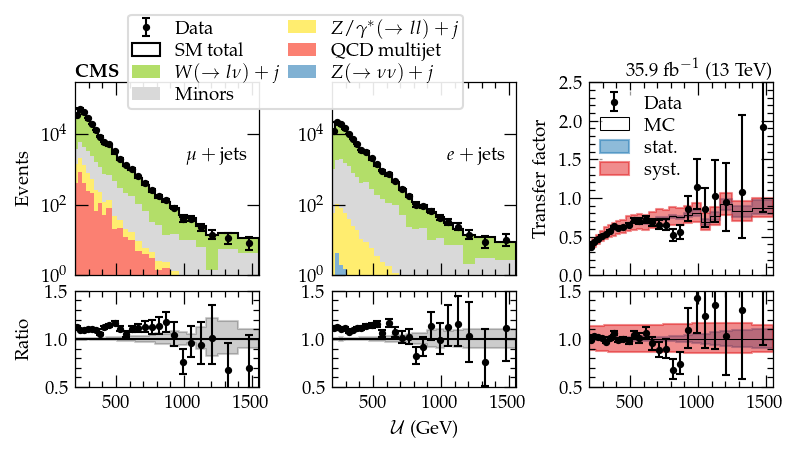

In [15]:
fig, ax = plt.subplots(
    figsize=(6, 3), dpi=150,
    nrows=3, ncols=3,
    sharex=True, sharey=False,
    gridspec_kw={
        "height_ratios": (0.2, 2,1),
        "hspace": 0.15, "wspace": 0.4,
    },
)

gs = ax[0,0].get_gridspec()
for sax in ax[0,:]:
    sax.remove()
axtop = fig.add_subplot(gs[0,:2])
axtop.axis('off')

bin_min = df_data.loc[("SingleMuon",)].index.get_level_values("bin_min").values
bin_max = df_data.loc[("SingleMuon",)].index.get_level_values("bin_max").values
bin_edges = np.array(list(bin_min)+[bin_max[-1]])

proc_cols = dftools.draw.process_colours
proc_cols["MinorBkgs"] = proc_cols["Minor"]
proc_labs = dftools.draw.process_names
proc_labs["MinorBkgs"] = "Minors"

tdf_mc = df_mc.loc[("SingleMuon",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,0], df_data.loc[("SingleMuon",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,0].set_ylim(1, 3e5)
ax[2,0].set_ylim(0.5, 1.5)

handles, labels = ax[1,0].get_legend_handles_labels()
axtop.legend(
    handles[::-1], labels[::-1],
    loc=10, labelspacing=0.1, borderpad=0.2,
    bbox_to_anchor=(0.5, 0.25),
    columnspacing=0.4, ncol=2,
    framealpha=0.9, edgecolor='#d9d9d9',
    fancybox=True,
    fontsize=9,
)

tdf_mc = df_mc.loc[("SingleElectron",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,1], df_data.loc[("SingleElectron",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,1].set_ylim(1, 3e5)
ax[2,1].set_ylim(0.5, 1.5)

numerator = ("SingleElectron", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
draw_transfer_factor(ax[1:,2], df_data, df_mc, numerator, denominator, _systs=systs)
ax[1,2].set_ylim(0., 2.5)
ax[2,2].set_ylim(0.5, 1.5)

#ax[2,0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel(r'$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel(r'$\mathcal{U}$ (GeV)')

legend = ax[1,0].legend([], [], title=r'$\mu+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)
legend = ax[1,1].legend([], [], title=r'$e+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)

ax[1,0].text(0,1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[1,0].transAxes)
ax[1,2].text(1,1, r'$35.9\ \mathrm{fb}^{-1}$ (13 TeV)', ha='right', va='bottom', transform=ax[1,2].transAxes)

ax[2,0].set_ylabel(r'Ratio')
ax[1,0].set_ylabel(r'Events')
fig.align_labels((ax[1,0], ax[2,0]))

ax[1,2].set_ylabel(r'Transfer factor')
fig.savefig("plots/tf_mu_e.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:51: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past le

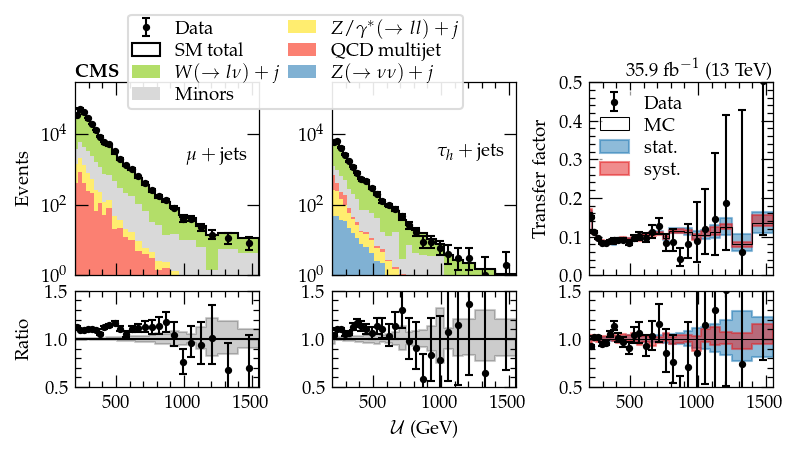

In [16]:
fig, ax = plt.subplots(
    figsize=(6, 3), dpi=150,
    nrows=3, ncols=3,
    sharex=True, sharey=False,
    gridspec_kw={
        "height_ratios": (0.2, 2,1),
        "hspace": 0.15, "wspace": 0.4,
    },
)

gs = ax[0,0].get_gridspec()
for sax in ax[0,:]:
    sax.remove()
axtop = fig.add_subplot(gs[0,:2])
axtop.axis('off')

bin_min = df_data.loc[("SingleMuon",)].index.get_level_values("bin_min").values
bin_max = df_data.loc[("SingleMuon",)].index.get_level_values("bin_max").values
bin_edges = np.array(list(bin_min)+[bin_max[-1]])

proc_cols = dftools.draw.process_colours
proc_cols["MinorBkgs"] = proc_cols["Minor"]
proc_labs = dftools.draw.process_names
proc_labs["MinorBkgs"] = "Minors"

tdf_mc = df_mc.loc[("SingleMuon",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,0], df_data.loc[("SingleMuon",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,0].set_ylim(1, 3e5)
ax[2,0].set_ylim(0.5, 1.5)

handles, labels = ax[1,0].get_legend_handles_labels()
axtop.legend(
    handles[::-1], labels[::-1],
    loc=10, labelspacing=0.1, borderpad=0.2,
    bbox_to_anchor=(0.5, 0.25),
    columnspacing=0.4, ncol=2,
    framealpha=0.9, edgecolor='#d9d9d9',
    fancybox=True,
    fontsize=9,
)

tdf_mc = df_mc.loc[("SingleTau",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,1], df_data.loc[("SingleTau",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,1].set_ylim(1, 3e5)
ax[2,1].set_ylim(0.5, 1.5)

numerator = ("SingleTau", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
draw_transfer_factor(ax[1:,2], df_data, df_mc, numerator, denominator, _systs=systs+["tauPtScale", "muonPtScale"])
ax[1,2].set_ylim(0., 0.5)
ax[2,2].set_ylim(0.5, 1.5)

#ax[2,0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel(r'$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel(r'$\mathcal{U}$ (GeV)')

legend = ax[1,0].legend([], [], title=r'$\mu+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)
legend = ax[1,1].legend([], [], title=r'$\tau_h+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)

ax[1,0].text(0,1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[1,0].transAxes)
ax[1,2].text(1,1, r'$35.9\ \mathrm{fb}^{-1}$ (13 TeV)', ha='right', va='bottom', transform=ax[1,2].transAxes)

ax[2,0].set_ylabel(r'Ratio')
ax[1,0].set_ylabel(r'Events')
fig.align_labels((ax[1,0], ax[2,0]))

ax[1,2].set_ylabel(r'Transfer factor')
fig.savefig("plots/tf_mu_tau.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.


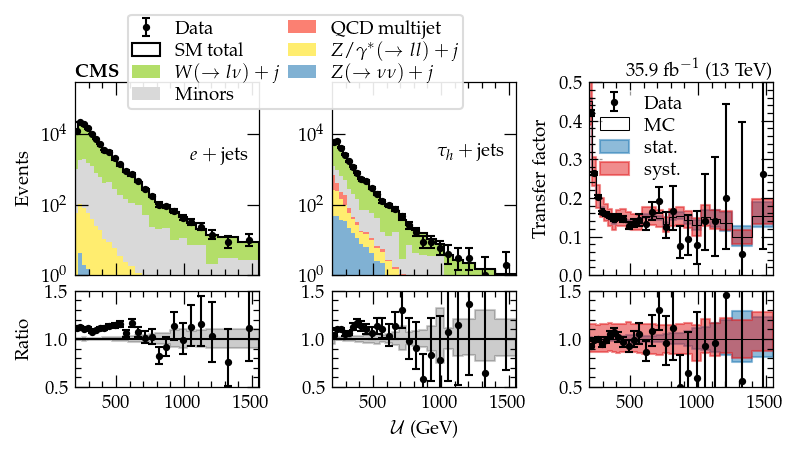

In [17]:
fig, ax = plt.subplots(
    figsize=(6, 3), dpi=150,
    nrows=3, ncols=3,
    sharex=True, sharey=False,
    gridspec_kw={
        "height_ratios": (0.2, 2,1),
        "hspace": 0.15, "wspace": 0.4,
    },
)

gs = ax[0,0].get_gridspec()
for sax in ax[0,:]:
    sax.remove()
axtop = fig.add_subplot(gs[0,:2])
axtop.axis('off')

bin_min = df_data.loc[("SingleElectron",)].index.get_level_values("bin_min").values
bin_max = df_data.loc[("SingleElectron",)].index.get_level_values("bin_max").values
bin_edges = np.array(list(bin_min)+[bin_max[-1]])

proc_cols = dftools.draw.process_colours
proc_cols["MinorBkgs"] = proc_cols["Minor"]
proc_labs = dftools.draw.process_names
proc_labs["MinorBkgs"] = "Minors"

tdf_mc = df_mc.loc[("SingleElectron",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,0], df_data.loc[("SingleElectron",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,0].set_ylim(1, 3e5)
ax[2,0].set_ylim(0.5, 1.5)

tdf_mc = df_mc.loc[("SingleTau",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,1], df_data.loc[("SingleTau",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,1].set_ylim(1, 3e5)
ax[2,1].set_ylim(0.5, 1.5)

handles, labels = ax[1,1].get_legend_handles_labels()
axtop.legend(
    handles[::-1], labels[::-1],
    loc=10, labelspacing=0.1, borderpad=0.2,
    bbox_to_anchor=(0.5, 0.25),
    columnspacing=0.4, ncol=2,
    framealpha=0.9, edgecolor='#d9d9d9',
    fancybox=True,
    fontsize=9,
)

numerator = ("SingleTau", "WJetsToLNu")
denominator = ("SingleElectron", "WJetsToLNu")
draw_transfer_factor(ax[1:,2], df_data, df_mc, numerator, denominator, _systs=systs+["tauPtScale"])
ax[1,2].set_ylim(0., 0.5)
ax[2,2].set_ylim(0.5, 1.5)

#ax[2,0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel(r'$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel(r'$\mathcal{U}$ (GeV)')

legend = ax[1,0].legend([], [], title=r'$e+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)
legend = ax[1,1].legend([], [], title=r'$\tau_h+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)

ax[1,0].text(0,1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[1,0].transAxes)
ax[1,2].text(1,1, r'$35.9\ \mathrm{fb}^{-1}$ (13 TeV)', ha='right', va='bottom', transform=ax[1,2].transAxes)

ax[2,0].set_ylabel(r'Ratio')
ax[1,0].set_ylabel(r'Events')
fig.align_labels((ax[1,0], ax[2,0]))

ax[1,2].set_ylabel(r'Transfer factor')
fig.savefig("plots/tf_e_tau.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.


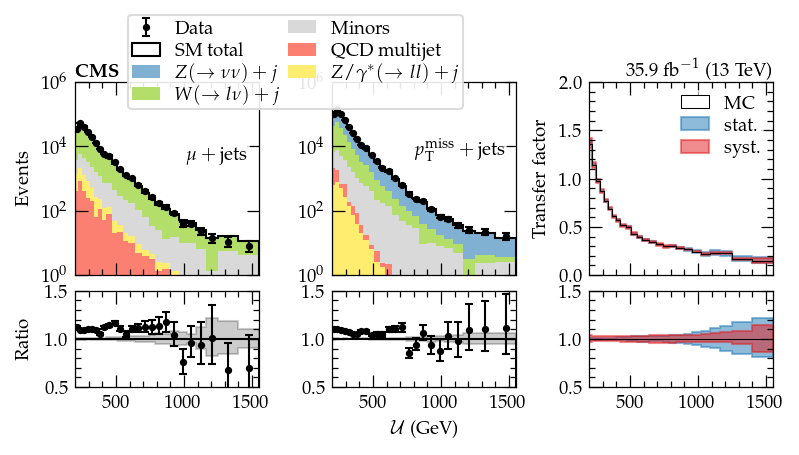

In [18]:
fig, ax = plt.subplots(
    figsize=(6, 3), dpi=150,
    nrows=3, ncols=3,
    sharex=True, sharey=False,
    gridspec_kw={
        "height_ratios": (0.2, 2,1),
        "hspace": 0.15, "wspace": 0.4,
    },
)

gs = ax[0,0].get_gridspec()
for sax in ax[0,:]:
    sax.remove()
axtop = fig.add_subplot(gs[0,:2])
axtop.axis('off')

bin_min = df_data.loc[("SingleMuon",)].index.get_level_values("bin_min").values
bin_max = df_data.loc[("SingleMuon",)].index.get_level_values("bin_max").values
bin_edges = np.array(list(bin_min)+[bin_max[-1]])

proc_cols = dftools.draw.process_colours
proc_cols["MinorBkgs"] = proc_cols["Minor"]
proc_labs = dftools.draw.process_names
proc_labs["MinorBkgs"] = "Minors"

tdf_mc = df_mc.loc[("SingleMuon",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,0], df_data.loc[("SingleMuon",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,0].set_ylim(1, 1e6)
ax[2,0].set_ylim(0.5, 1.5)

tdf_mc = df_mc.loc[("Monojet",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,1], df_data.loc[("Monojet",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,1].set_ylim(1, 1e6)
ax[2,1].set_ylim(0.5, 1.5)

handles, labels = ax[1,1].get_legend_handles_labels()
axtop.legend(
    handles[::-1], labels[::-1],
    loc=10, labelspacing=0.1, borderpad=0.2,
    bbox_to_anchor=(0.5, 0.25),
    columnspacing=0.4, ncol=2,
    framealpha=0.9, edgecolor='#d9d9d9',
    fancybox=True,
    fontsize=9,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
draw_transfer_factor(ax[1:,2], df_data, df_mc, numerator, denominator, _systs=systs, draw_data=False)
ax[1,2].set_ylim(0., 2.)
ax[2,2].set_ylim(0.5, 1.5)

#ax[2,0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel(r'$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel(r'$\mathcal{U}$ (GeV)')

legend = ax[1,0].legend([], [], title=r'$\mu+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)
legend = ax[1,1].legend([], [], title=r'$p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)

ax[1,0].text(0,1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[1,0].transAxes)
ax[1,2].text(1,1, r'$35.9\ \mathrm{fb}^{-1}$ (13 TeV)', ha='right', va='bottom', transform=ax[1,2].transAxes)

ax[2,0].set_ylabel(r'Ratio')
ax[1,0].set_ylabel(r'Events')
fig.align_labels((ax[1,0], ax[2,0]))

ax[1,2].set_ylabel(r'Transfer factor')
fig.savefig("plots/tf_mu_sr.pdf", format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.


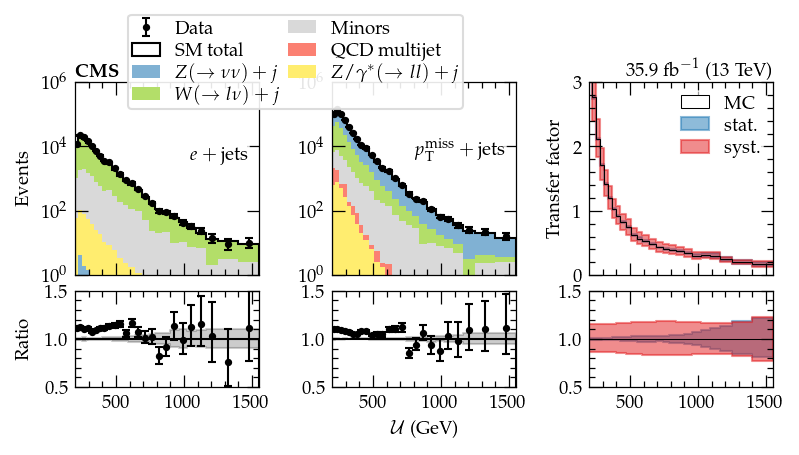

In [19]:
fig, ax = plt.subplots(
    figsize=(6, 3), dpi=150,
    nrows=3, ncols=3,
    sharex=True, sharey=False,
    gridspec_kw={
        "height_ratios": (0.2, 2,1),
        "hspace": 0.15, "wspace": 0.4,
    },
)

gs = ax[0,0].get_gridspec()
for sax in ax[0,:]:
    sax.remove()
axtop = fig.add_subplot(gs[0,:2])
axtop.axis('off')

bin_min = df_data.loc[("SingleElectron",)].index.get_level_values("bin_min").values
bin_max = df_data.loc[("SingleElectron",)].index.get_level_values("bin_max").values
bin_edges = np.array(list(bin_min)+[bin_max[-1]])

proc_cols = dftools.draw.process_colours
proc_cols["MinorBkgs"] = proc_cols["Minor"]
proc_labs = dftools.draw.process_names
proc_labs["MinorBkgs"] = "Minors"

tdf_mc = df_mc.loc[("SingleElectron",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,0], df_data.loc[("SingleElectron",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,0].set_ylim(1, 1e6)
ax[2,0].set_ylim(0.5, 1.5)

tdf_mc = df_mc.loc[("Monojet",pd.IndexSlice[:],"")].groupby(["process", "bin_min", "bin_max"]).sum()
tdf_mc.index.names = ["parent", "bin_min", "bin_max"]
dftools.draw.data_mc(
    ax[1:,1], df_data.loc[("Monojet",)], tdf_mc,
    "bin_min", bin_min,
    proc_kw={"colours": proc_cols, "labels": proc_labs},
    legend=False,
)
ax[1,1].set_ylim(1, 1e6)
ax[2,1].set_ylim(0.5, 1.5)

handles, labels = ax[1,1].get_legend_handles_labels()
axtop.legend(
    handles[::-1], labels[::-1],
    loc=10, labelspacing=0.1, borderpad=0.2,
    bbox_to_anchor=(0.5, 0.25),
    columnspacing=0.4, ncol=2,
    framealpha=0.9, edgecolor='#d9d9d9',
    fancybox=True,
    fontsize=9,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleElectron", "WJetsToLNu")
draw_transfer_factor(ax[1:,2], df_data, df_mc, numerator, denominator, _systs=systs, draw_data=False)
ax[1,2].set_ylim(0., 3.)
ax[2,2].set_ylim(0.5, 1.5)

#ax[2,0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel(r'$\mathcal{U}$ (GeV)')
#ax[2,2].set_xlabel(r'$\mathcal{U}$ (GeV)')

legend = ax[1,0].legend([], [], title=r'$e+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)
legend = ax[1,1].legend([], [], title=r'$p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$', loc=7, bbox_to_anchor=(1., 0.6), borderpad=0.1)
plt.setp(legend.get_title(), fontsize=9)

ax[1,0].text(0,1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[1,0].transAxes)
ax[1,2].text(1,1, r'$35.9\ \mathrm{fb}^{-1}$ (13 TeV)', ha='right', va='bottom', transform=ax[1,2].transAxes)

ax[2,0].set_ylabel(r'Ratio')
ax[1,0].set_ylabel(r'Events')
fig.align_labels((ax[1,0], ax[2,0]))

ax[1,2].set_ylabel(r'Transfer factor')
fig.savefig("plots/tf_e_sr.pdf", format='pdf', bbox_inches='tight')
pass

# Systematics

In [20]:
#list(df_mc.index.get_level_values("variation").unique())
systs = [
    "d1kew", "d1kqcd", "d2keww", "d2kewz", "d2kqcd", "d3keww", "d3kewz", "d3kqcd", "dkmix", "lheScaleWeight", "lhePdfWeight",
    "btagSF",
    "eleIdIsoTight", "eleIdIsoVeto", "eleReco", "eleTrig",
    "jerSF", "jesTotal", "unclust",
    "lumi", "pileup", "prefiring",
    "metTrig0MuSyst", "metTrig1MuSyst", "metTrig2MuSyst",
    "metTrigReferenceTriggerSyst",
    "metTrigMonojetSyst", "metTrigSingleMuonSyst", "metTrigDoubleMuonSyst",
    "metTrigSingleTauSyst", "metTrigSingleElectronSyst", "metTrigDoubleElectronSyst",
    "muonIdLooseStat", "muonIdLooseSyst", "muonIsoLooseStat", "muonIsoLooseSyst",
    "muonIdTightStat", "muonIdTightSyst", "muonIsoTightStat", "muonIsoTightSyst",
    "photonIdLoose", "photonPixelSeedVeto",
    "tauIdVLoose", "tightIdTight",
]

In [41]:
def draw_systematics(ax, dfdata, dfmc, numerator, denominator, _all_systs=[], _systs=[], labels={}, legkw={}):
    #mc_tf_stat = transfer_factor(df_mc, numerator, denominator, systs=["statNumerator", "statDenominator"])
    #mc_tf_syst = transfer_factor(df_mc, numerator, denominator, systs=systs)
    mc_tf_tot = transfer_factor(dfmc, numerator, denominator, _systs=_all_systs)#+["statNumerator", "statDenominator"])

    bin_min = dfdata.loc[(numerator[0],),:].index.get_level_values("bin_min")
    bin_max = dfdata.loc[(numerator[0],),:].index.get_level_values("bin_max")
    bin_edges = np.array(list(bin_min)+[bin_max[-1]])
    ax.set_xlim(bin_min[0], bin_max[-1])

    ax.hist(
        bin_min, bins=bin_edges, weights=100*mc_tf_tot.loc["totalUp"]/mc_tf_tot.loc[""],
        histtype='step', color='black', lw=1,
        label="Total",
    )
    ax.hist(
        bin_min, bins=bin_edges, weights=-100*mc_tf_tot.loc["totalDown"]/mc_tf_tot.loc[""],
        histtype='step', color='black', lw=1,
    )

    colors = plt.cm.Spectral(np.linspace(0.05, 0.95, len(_systs)))
    for idx, variation in enumerate(_systs):
        ax.hist(
            bin_min, bins=bin_edges, weights=100*(mc_tf_tot.loc[f'{variation}Up']/mc_tf_tot.loc[""]-1),
            histtype='step', color=colors[idx], label=labels.get(variation, variation),
        )
        ax.hist(
            bin_min, bins=bin_edges, weights=100*(mc_tf_tot.loc[f'{variation}Down']/mc_tf_tot.loc[""]-1),
            histtype='step', color=colors[idx],
        )
    ax.legend(**legkw)

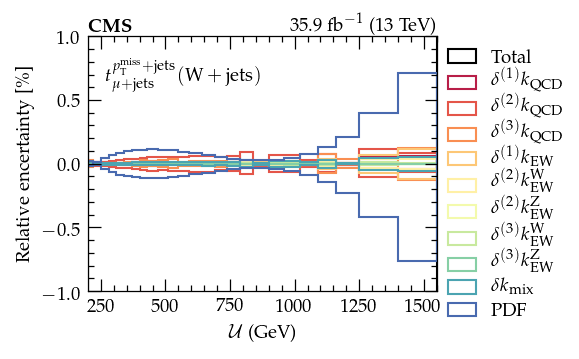

In [31]:
fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")

draw_systematics(
    ax, df_data, df_mc, numerator, denominator, _all_systs=systs,
    _systs=[
        "d1kqcd", "d2kqcd", "d3kqcd",
        "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix",
        "lhePdfWeight",
    ], labels={
        "d1kqcd": r'$\delta^{(1)}k_{\mathrm{QCD}}$',
        "d2kqcd": r'$\delta^{(2)}k_{\mathrm{QCD}}$',
        "d3kqcd": r'$\delta^{(3)}k_{\mathrm{QCD}}$',
        "d1kew":  r'$\delta^{(1)}k_{\mathrm{EW}}$',
        "d2keww": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{W}}$',
        "d2kewz": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{Z}}$',
        "d3keww": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{W}}$',
        "d3kewz": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{Z}}$',
        "dkmix":  r'$\delta k_{\mathrm{mix}}$',
        "lhePdfWeight": r'PDF',
    },
)

dftools.draw.cms_label(ax, "")
ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Relative encertainty [\%]')
ax.set_ylim(-1, 1)

ax.text(
    0.05, 0.8, r'$t_{\mu+\mathrm{jets}}^{p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}}(\mathrm{W}+\mathrm{jets})$',
    transform=ax.transAxes,
)
fig.savefig("plots/tf_wj_mu_met_systs_theory.pdf", format='pdf', bbox_inches="tight")

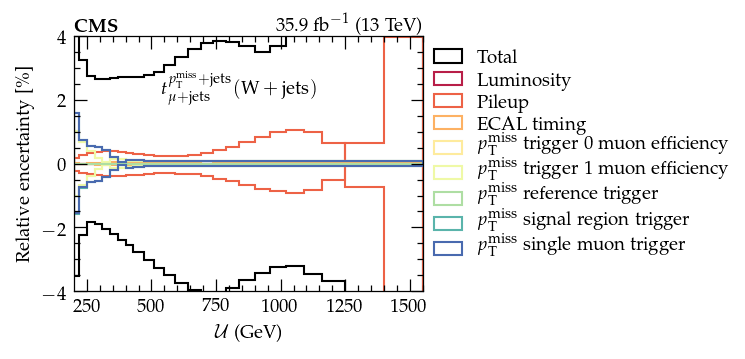

In [32]:
fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")

draw_systematics(
    ax, df_data, df_mc, numerator, denominator, _all_systs=systs,
    _systs=[
        "lumi", "pileup", "prefiring",
        "metTrig0MuSyst", "metTrig1MuSyst",
        "metTrigReferenceTriggerSyst",
        "metTrigMonojetSyst", "metTrigSingleMuonSyst",
    ],
    labels={
        "lumi": r'Luminosity',
        "pileup": r'Pileup',
        "prefiring": r'ECAL timing',
        "metTrig0MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $0$ muon efficiency',
        "metTrig1MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $1$ muon efficiency',
        "metTrigReferenceTriggerSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ reference trigger',
        "metTrigMonojetSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ signal region trigger',
        "metTrigSingleMuonSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ single muon trigger',
    },
)

dftools.draw.cms_label(ax, "")
ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Relative encertainty [\%]')
ax.set_ylim(-4, 4)

ax.text(
    0.25, 0.75, r'$t_{\mu+\mathrm{jets}}^{p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}}(\mathrm{W}+\mathrm{jets})$',
    transform=ax.transAxes,
)
fig.savefig("plots/tf_wj_mu_met_systs_exp.pdf", format='pdf', bbox_inches="tight")

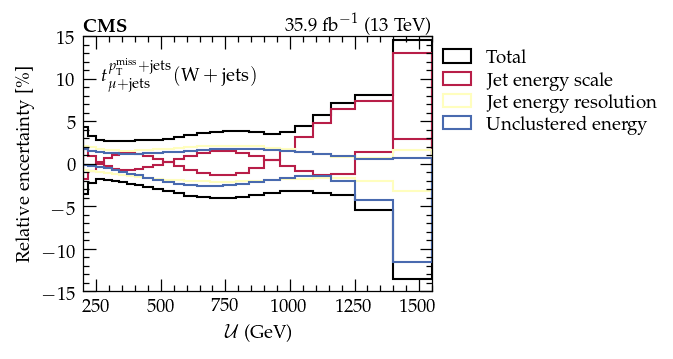

In [33]:
fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")

draw_systematics(
    ax, df_data, df_mc, numerator, denominator, _all_systs=systs,
    _systs=["jesTotal", "jerSF", "unclust"],
    labels={
        "jesTotal": r'Jet energy scale',
        "jerSF": r'Jet energy resolution',
        "unclust": r'Unclustered energy',
    },
)

dftools.draw.cms_label(ax, "")
ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Relative encertainty [\%]')
ax.set_ylim(-15, 15)

ax.text(
    0.05, 0.8, r'$t_{\mu+\mathrm{jets}}^{p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}}(\mathrm{W}+\mathrm{jets})$',
    transform=ax.transAxes,
)
fig.savefig("plots/tf_wj_mu_met_systs_expjet.pdf", format='pdf', bbox_inches="tight")

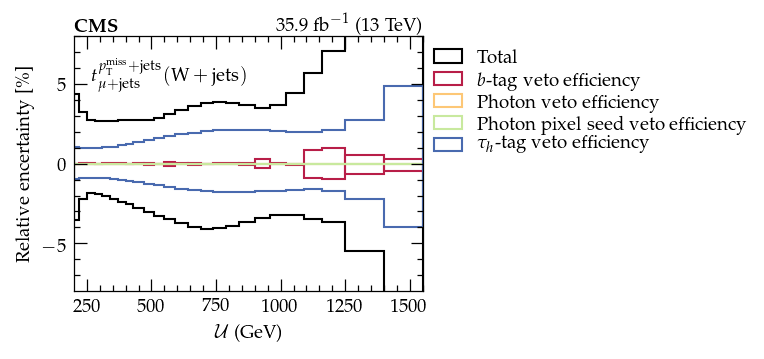

In [34]:
fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")

draw_systematics(
    ax, df_data, df_mc, numerator, denominator, _all_systs=systs,
    _systs=[
        "btagSF",
        "photonIdLoose", "photonPixelSeedVeto",
        "tauIdVLoose",
    ],
    labels={
        "btagSF": r'$b$-tag veto efficiency',
        "photonIdLoose": r'Photon veto efficiency',
        "photonPixelSeedVeto": r'Photon pixel seed veto efficiency',
        "tauIdVLoose": r'$\tau_h$-tag veto efficiency',
    },
)

dftools.draw.cms_label(ax, "")
ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Relative encertainty [\%]')
ax.set_ylim(-8, 8)

ax.text(
    0.05, 0.8, r'$t_{\mu+\mathrm{jets}}^{p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}}(\mathrm{W}+\mathrm{jets})$',
    transform=ax.transAxes,
)
fig.savefig("plots/tf_wj_mu_met_systs_expveto.pdf", format='pdf', bbox_inches="tight")

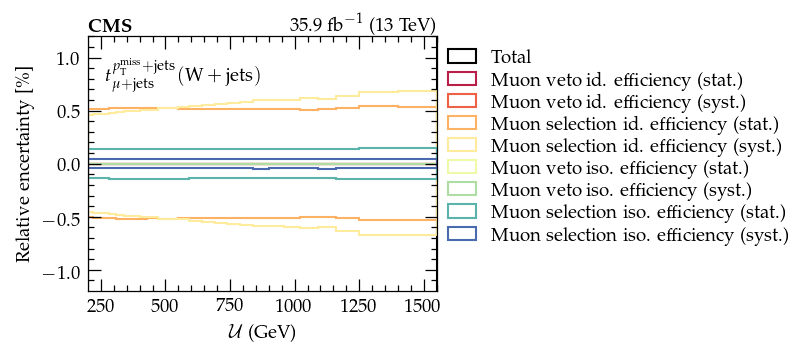

In [27]:
fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")

draw_systematics(
    ax, df_data, df_mc, numerator, denominator, _all_systs=systs,
    _systs=[
        "muonIdLooseStat", "muonIdLooseSyst",
        "muonIdTightStat", "muonIdTightSyst",
        "muonIsoLooseStat", "muonIsoLooseSyst",
        "muonIsoTightStat", "muonIsoTightSyst",
    ],
    labels={
        "muonIdLooseStat": r'Muon veto id. efficiency (stat.)',
        "muonIdLooseSyst": r'Muon veto id. efficiency (syst.)',
        "muonIsoLooseStat": r'Muon veto iso. efficiency (stat.)',
        "muonIsoLooseSyst": r'Muon veto iso. efficiency (syst.)',
        "muonIdTightStat": r'Muon selection id. efficiency (stat.)',
        "muonIdTightSyst": r'Muon selection id. efficiency (syst.)',
        "muonIsoTightStat": r'Muon selection iso. efficiency (stat.)',
        "muonIsoTightSyst": r'Muon selection iso. efficiency (syst.)',
    },
)

dftools.draw.cms_label(ax, "")
ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Relative encertainty [\%]')
ax.set_ylim(-1.2, 1.2)

ax.text(
    0.05, 0.8, r'$t_{\mu+\mathrm{jets}}^{p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}}(\mathrm{W}+\mathrm{jets})$',
    transform=ax.transAxes,
)
fig.savefig("plots/tf_wj_mu_met_systs_expmuon.pdf", format='pdf', bbox_inches="tight")

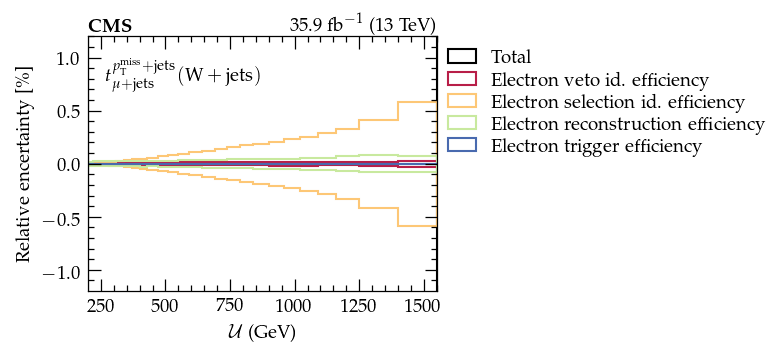

In [35]:
fig, ax = plt.subplots(
    figsize=(3, 2.25), dpi=150,
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")

draw_systematics(
    ax, df_data, df_mc, numerator, denominator, _all_systs=systs,
    _systs=[
        "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig",
    ],
    labels={
        "eleIdIsoVeto": r'Electron veto id. efficiency',
        "eleIdIsoTight": r'Electron selection id. efficiency',
        "eleReco": r'Electron reconstruction efficiency',
        "eleTrig": r'Electron trigger efficiency',
    },
)

dftools.draw.cms_label(ax, "")
ax.set_xlabel(r'$\mathcal{U}$ (GeV)')
ax.set_ylabel(r'Relative encertainty [\%]')
ax.set_ylim(-1.2, 1.2)

ax.text(
    0.05, 0.8, r'$t_{\mu+\mathrm{jets}}^{p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}}(\mathrm{W}+\mathrm{jets})$',
    transform=ax.transAxes,
)
fig.savefig("plots/tf_wj_mu_met_systs_expele.pdf", format='pdf', bbox_inches="tight")

In [29]:
numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
mc_tf_tot = transfer_factor(df_mc, numerator, denominator, _systs=systs)

for variation in systs:
    nom = mc_tf_tot.loc[""].values
    up = mc_tf_tot.loc["{}Up".format(variation)].values
    do = mc_tf_tot.loc["{}Down".format(variation)].values
    
    vals = list(np.abs(100.*(up/nom-1.)))+list(np.abs(100.*(do/nom-1.)))
    print("{}: {:.3f} - {:.3f}".format(variation, min(vals), max(vals)))

d1kew: 0.001 - 0.121
d1kqcd: 0.000 - 0.060
d2keww: 0.002 - 0.038
d2kewz: 0.000 - 0.000
d2kqcd: 0.007 - 0.119
d3keww: 0.001 - 0.010
d3kewz: 0.000 - 0.000
d3kqcd: 0.003 - 0.126
dkmix: 0.004 - 0.058
lheScaleWeight: 0.000 - 0.000
lhePdfWeight: 0.012 - 0.761
btagSF: 0.000 - 1.013
eleIdIsoTight: 0.009 - 0.588
eleIdIsoVeto: 0.008 - 0.027
eleReco: 0.021 - 0.081
eleTrig: 0.000 - 0.000
jerSF: 0.700 - 3.241
jesTotal: 0.006 - 13.013
unclust: 0.137 - 11.604
lumi: 0.000 - 0.000
pileup: 0.190 - 4.760
prefiring: 0.000 - 0.046
metTrig0MuSyst: 0.047 - 1.029
metTrig1MuSyst: 0.048 - 1.035
metTrig2MuSyst: 0.000 - 0.000
metTrigReferenceTriggerSyst: 0.000 - 0.000
metTrigMonojetSyst: 0.048 - 1.581
metTrigSingleMuonSyst: 0.048 - 1.589
metTrigDoubleMuonSyst: 0.000 - 0.000
metTrigSingleTauSyst: 0.000 - 0.000
metTrigSingleElectronSyst: 0.000 - 0.000
metTrigDoubleElectronSyst: 0.000 - 0.000
muonIdLooseStat: 0.000 - 0.001
muonIdLooseSyst: 0.000 - 0.002
muonIsoLooseStat: 0.000 - 0.000
muonIsoLooseSyst: 0.000 - 0.000

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


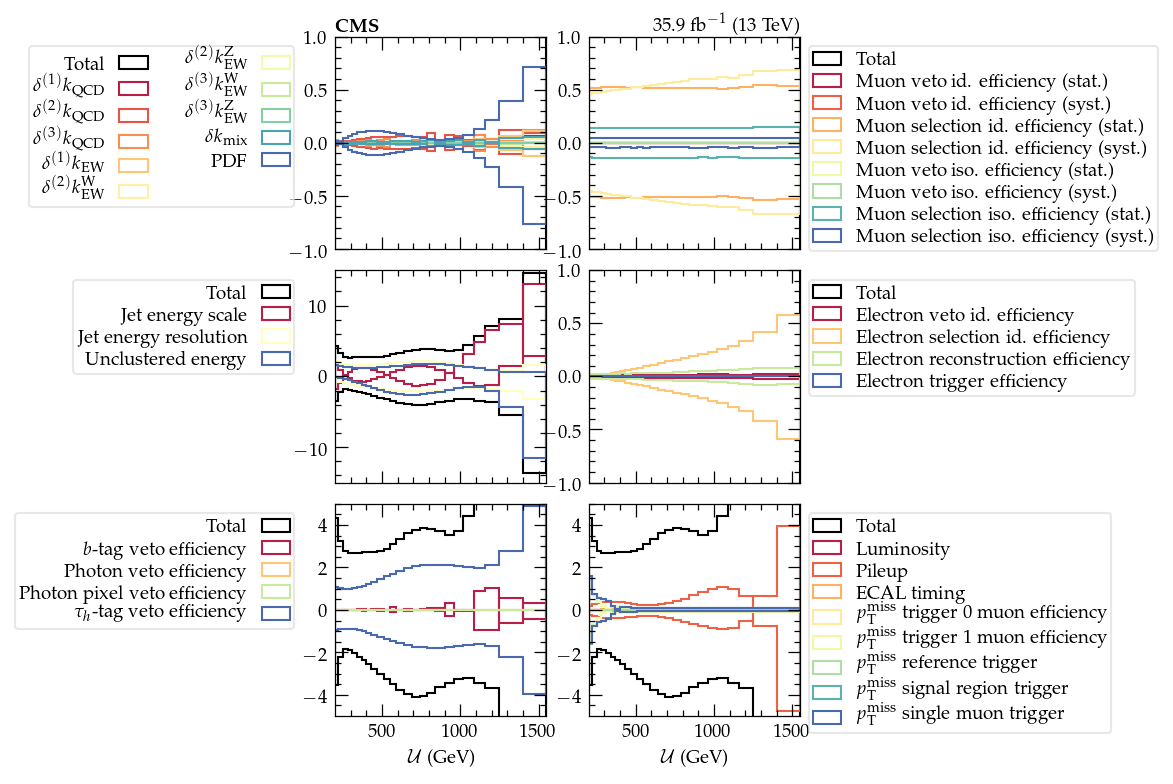

In [61]:
fig, ax = plt.subplots(
    figsize=(4,6), dpi=150,
    nrows=3, ncols=2,
    sharex=True, sharey=False,
    gridspec_kw={
        "hspace": 0.1, "wspace": 0.2,
    }
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
labels={
    "d1kqcd": r'$\delta^{(1)}k_{\mathrm{QCD}}$', "d2kqcd": r'$\delta^{(2)}k_{\mathrm{QCD}}$', "d3kqcd": r'$\delta^{(3)}k_{\mathrm{QCD}}$',
    "d1kew":  r'$\delta^{(1)}k_{\mathrm{EW}}$', "d2keww": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{W}}$', "d2kewz": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{Z}}$',
    "d3keww": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{W}}$', "d3kewz": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{Z}}$', "dkmix":  r'$\delta k_{\mathrm{mix}}$',
    "lhePdfWeight": r'PDF', "lumi": r'Luminosity', "pileup": r'Pileup', "prefiring": r'ECAL timing',
    "metTrig0MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $0$ muon efficiency', "metTrig1MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $1$ muon efficiency',
    "metTrigReferenceTriggerSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ reference trigger', "metTrigMonojetSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ signal region trigger',
    "metTrigSingleMuonSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ single muon trigger',
    "jesTotal": r'Jet energy scale', "jerSF": r'Jet energy resolution', "unclust": r'Unclustered energy',
    "btagSF": r'$b$-tag veto efficiency', "photonIdLoose": r'Photon veto efficiency', "photonPixelSeedVeto": r'Photon pixel veto efficiency', "tauIdVLoose": r'$\tau_h$-tag veto efficiency',
    "muonIdLooseStat": r'Muon veto id. efficiency (stat.)', "muonIdLooseSyst": r'Muon veto id. efficiency (syst.)', "muonIsoLooseStat": r'Muon veto iso. efficiency (stat.)', "muonIsoLooseSyst": r'Muon veto iso. efficiency (syst.)',
    "muonIdTightStat": r'Muon selection id. efficiency (stat.)', "muonIdTightSyst": r'Muon selection id. efficiency (syst.)', "muonIsoTightStat": r'Muon selection iso. efficiency (stat.)', "muonIsoTightSyst": r'Muon selection iso. efficiency (syst.)',
    "eleIdIsoVeto": r'Electron veto id. efficiency', "eleIdIsoTight": r'Electron selection id. efficiency', "eleReco": r'Electron reconstruction efficiency', "eleTrig": r'Electron trigger efficiency',
}

for idx, syst_group in enumerate([
    ("d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix", "lhePdfWeight"),
    ("lumi", "pileup", "prefiring", "metTrig0MuSyst", "metTrig1MuSyst", "metTrigReferenceTriggerSyst", "metTrigMonojetSyst", "metTrigSingleMuonSyst"),
    ("btagSF", "photonIdLoose", "photonPixelSeedVeto", "tauIdVLoose"),
    #("muonIdLooseStat", "muonIdLooseSyst", "muonIdTightStat", "muonIdTightSyst", "muonIsoLooseStat", "muonIsoLooseSyst", "muonIsoTightStat", "muonIsoTightSyst"),
    #("jesTotal", "jerSF", "unclust"),
    #("eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig"),
]):
    row = idx//2
    col = idx%2
    
    if col%2==1:
        legkw = dict(loc=2, bbox_to_anchor=(1,1))
    else:
        legkw = dict(loc=1, bbox_to_anchor=(-0.15, 1), markerfirst=False)
    if (row, col) == (0,0):
        legkw = dict(loc=1, bbox_to_anchor=(-0.15, 1), markerfirst=False, ncol=2)
    legkw.update({
        "labelspacing": 0.1, "borderpad": 0.2,
        "fancybox": True, "edgecolor": "#d9d9d9",
    })
    
    draw_systematics(
        ax[row, col], df_data, df_mc, numerator, denominator, _all_systs=systs,
        _systs=syst_group, labels=labels, legkw=legkw,
    )

ax[0,0].set_ylim(-1, 1)
ax[0,1].set_ylim(-1, 1)
ax[1,0].set_ylim(-15, 15)
ax[1,1].set_ylim(-1, 1)
ax[2,0].set_ylim(-5, 5)
ax[2,1].set_ylim(-5, 5)

ax[2,0].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel(r'$\mathcal{U}$ (GeV)')

ax[0,0].text(
    0, 1, r'$\mathbf{CMS}$',
    transform=ax[0,0].transAxes,
    ha='left', va='bottom',
)
ax[0,1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)',
    transform=ax[0,1].transAxes,
    ha='right', va='bottom',
)
fig.savefig('plots/tf_wj_mu_met_systs.pdf', format='pdf', bbox_inches='tight')
pass

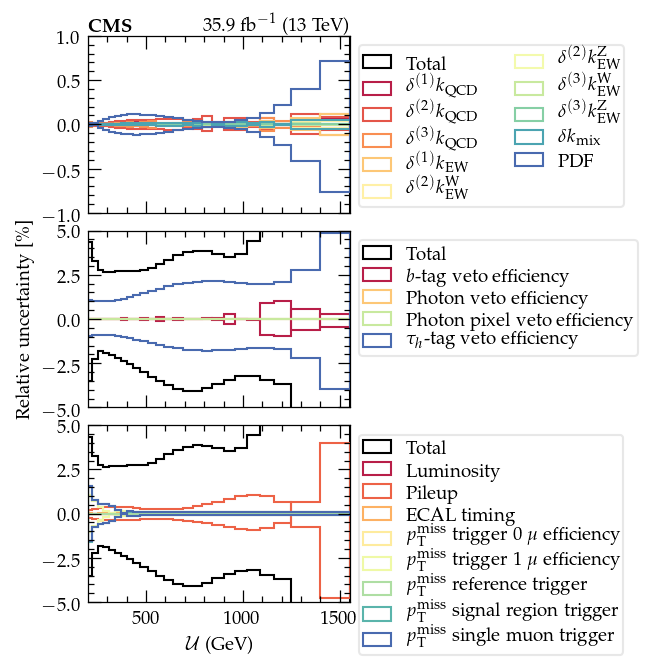

In [76]:
fig, ax = plt.subplots(
    figsize=(2.25,5), dpi=150,
    nrows=3, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={
        "hspace": 0.1, "wspace": 0.2,
    }
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
labels={
    "d1kqcd": r'$\delta^{(1)}k_{\mathrm{QCD}}$', "d2kqcd": r'$\delta^{(2)}k_{\mathrm{QCD}}$', "d3kqcd": r'$\delta^{(3)}k_{\mathrm{QCD}}$',
    "d1kew":  r'$\delta^{(1)}k_{\mathrm{EW}}$', "d2keww": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{W}}$', "d2kewz": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{Z}}$',
    "d3keww": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{W}}$', "d3kewz": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{Z}}$', "dkmix":  r'$\delta k_{\mathrm{mix}}$',
    "lhePdfWeight": r'PDF', "lumi": r'Luminosity', "pileup": r'Pileup', "prefiring": r'ECAL timing',
    "metTrig0MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $0\ \mu$ efficiency', "metTrig1MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $1\ \mu$ efficiency',
    "metTrigReferenceTriggerSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ reference trigger', "metTrigMonojetSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ signal region trigger',
    "metTrigSingleMuonSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ single muon trigger',
    "jesTotal": r'Jet energy scale', "jerSF": r'Jet energy resolution', "unclust": r'Unclustered energy',
    "btagSF": r'$b$-tag veto efficiency', "photonIdLoose": r'Photon veto efficiency', "photonPixelSeedVeto": r'Photon pixel veto efficiency', "tauIdVLoose": r'$\tau_h$-tag veto efficiency',
    "muonIdLooseStat": r'Muon veto id. efficiency (stat.)', "muonIdLooseSyst": r'Muon veto id. efficiency (syst.)', "muonIsoLooseStat": r'Muon veto iso. efficiency (stat.)', "muonIsoLooseSyst": r'Muon veto iso. efficiency (syst.)',
    "muonIdTightStat": r'Muon selection id. efficiency (stat.)', "muonIdTightSyst": r'Muon selection id. efficiency (syst.)', "muonIsoTightStat": r'Muon selection iso. efficiency (stat.)', "muonIsoTightSyst": r'Muon selection iso. efficiency (syst.)',
    "eleIdIsoVeto": r'Electron veto id. efficiency', "eleIdIsoTight": r'Electron selection id. efficiency', "eleReco": r'Electron reconstruction efficiency', "eleTrig": r'Electron trigger efficiency',
}

for idx, syst_group in enumerate([
    ("d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix", "lhePdfWeight"),
    ("btagSF", "photonIdLoose", "photonPixelSeedVeto", "tauIdVLoose"),
    ("lumi", "pileup", "prefiring", "metTrig0MuSyst", "metTrig1MuSyst", "metTrigReferenceTriggerSyst", "metTrigMonojetSyst", "metTrigSingleMuonSyst"),
    #("muonIdLooseStat", "muonIdLooseSyst", "muonIdTightStat", "muonIdTightSyst", "muonIsoLooseStat", "muonIsoLooseSyst", "muonIsoTightStat", "muonIsoTightSyst"),
    #("jesTotal", "jerSF", "unclust"),
    #("eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig"),
]):
    legkw = dict(loc=2, bbox_to_anchor=(1,1))
    legkw.update({
        "labelspacing": 0.1, "borderpad": 0.2,
        "fancybox": True, "edgecolor": "#d9d9d9",
    })
    
    if idx==0:
        legkw.update({"ncol": 2})
    
    draw_systematics(
        ax[idx], df_data, df_mc, numerator, denominator, _all_systs=systs,
        _systs=syst_group, labels=labels, legkw=legkw,
    )

ax[0].set_ylim(-1, 1)
ax[1].set_ylim(-5, 5)
ax[2].set_ylim(-5, 5)
#ax[0,1].set_ylim(-1, 1)
#ax[1,0].set_ylim(-15, 15)
#ax[1,1].set_ylim(-1, 1)

ax[2].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[1].set_ylabel(r'Relative uncertainty [\%]')

dftools.draw.cms_label(ax[0], "")
fig.savefig('plots/tf_wj_mu_met_systs1.pdf', format='pdf', bbox_inches='tight')
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


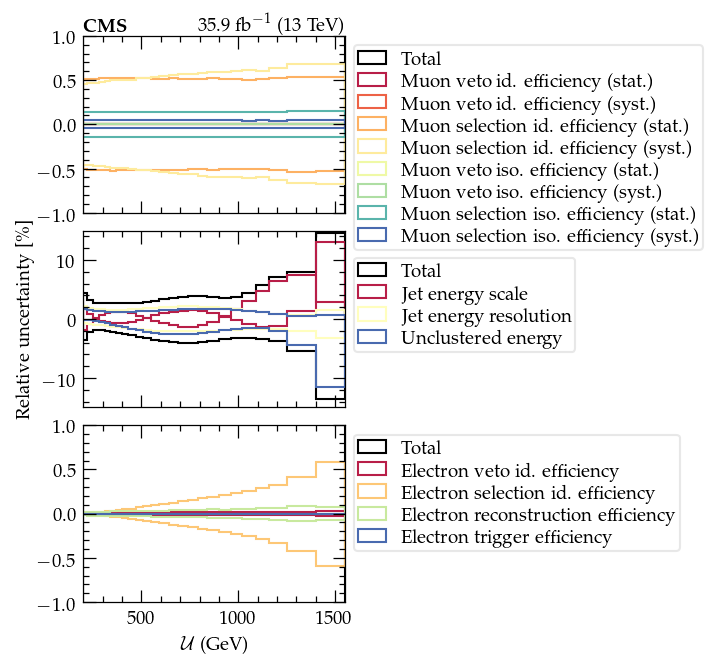

In [77]:
fig, ax = plt.subplots(
    figsize=(2.25,5), dpi=150,
    nrows=3, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={
        "hspace": 0.1, "wspace": 0.2,
    }
)

numerator = ("Monojet", "WJetsToLNu")
denominator = ("SingleMuon", "WJetsToLNu")
labels={
    "d1kqcd": r'$\delta^{(1)}k_{\mathrm{QCD}}$', "d2kqcd": r'$\delta^{(2)}k_{\mathrm{QCD}}$', "d3kqcd": r'$\delta^{(3)}k_{\mathrm{QCD}}$',
    "d1kew":  r'$\delta^{(1)}k_{\mathrm{EW}}$', "d2keww": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{W}}$', "d2kewz": r'$\delta^{(2)}k_{\mathrm{EW}}^{\mathrm{Z}}$',
    "d3keww": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{W}}$', "d3kewz": r'$\delta^{(3)}k_{\mathrm{EW}}^{\mathrm{Z}}$', "dkmix":  r'$\delta k_{\mathrm{mix}}$',
    "lhePdfWeight": r'PDF', "lumi": r'Luminosity', "pileup": r'Pileup', "prefiring": r'ECAL timing',
    "metTrig0MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $0$ muon efficiency', "metTrig1MuSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger $1$ muon efficiency',
    "metTrigReferenceTriggerSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ reference trigger', "metTrigMonojetSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ signal region trigger',
    "metTrigSingleMuonSyst": r'$p_{\mathrm{T}}^{\mathrm{miss}}$ single muon trigger',
    "jesTotal": r'Jet energy scale', "jerSF": r'Jet energy resolution', "unclust": r'Unclustered energy',
    "btagSF": r'$b$-tag veto efficiency', "photonIdLoose": r'Photon veto efficiency', "photonPixelSeedVeto": r'Photon pixel veto efficiency', "tauIdVLoose": r'$\tau_h$-tag veto efficiency',
    "muonIdLooseStat": r'Muon veto id. efficiency (stat.)', "muonIdLooseSyst": r'Muon veto id. efficiency (syst.)', "muonIsoLooseStat": r'Muon veto iso. efficiency (stat.)', "muonIsoLooseSyst": r'Muon veto iso. efficiency (syst.)',
    "muonIdTightStat": r'Muon selection id. efficiency (stat.)', "muonIdTightSyst": r'Muon selection id. efficiency (syst.)', "muonIsoTightStat": r'Muon selection iso. efficiency (stat.)', "muonIsoTightSyst": r'Muon selection iso. efficiency (syst.)',
    "eleIdIsoVeto": r'Electron veto id. efficiency', "eleIdIsoTight": r'Electron selection id. efficiency', "eleReco": r'Electron reconstruction efficiency', "eleTrig": r'Electron trigger efficiency',
}

for idx, syst_group in enumerate([
    #("d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix", "lhePdfWeight"),
    #("lumi", "pileup", "prefiring", "metTrig0MuSyst", "metTrig1MuSyst", "metTrigReferenceTriggerSyst", "metTrigMonojetSyst", "metTrigSingleMuonSyst"),
    #("btagSF", "photonIdLoose", "photonPixelSeedVeto", "tauIdVLoose"),
    ("muonIdLooseStat", "muonIdLooseSyst", "muonIdTightStat", "muonIdTightSyst", "muonIsoLooseStat", "muonIsoLooseSyst", "muonIsoTightStat", "muonIsoTightSyst"),
    ("jesTotal", "jerSF", "unclust"),
    ("eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig"),
]):
    legkw = dict(loc=2, bbox_to_anchor=(1,1))
    legkw.update({
        "labelspacing": 0.1, "borderpad": 0.2,
        "fancybox": True, "edgecolor": "#d9d9d9",
    })
    if idx==1:
        legkw.update({
            "bbox_to_anchor": (1, 0.9),
        })
    
    draw_systematics(
        ax[idx], df_data, df_mc, numerator, denominator, _all_systs=systs,
        _systs=syst_group, labels=labels, legkw=legkw,
    )

ax[0].set_ylim(-1, 1)
ax[1].set_ylim(-15, 15)
ax[2].set_ylim(-1, 1)

ax[2].set_xlabel(r'$\mathcal{U}$ (GeV)')
ax[1].set_ylabel(r'Relative uncertainty [\%]')

dftools.draw.cms_label(ax[0], "")
fig.savefig('plots/tf_wj_mu_met_systs2.pdf', format='pdf', bbox_inches='tight')
pass